# <center> Taller Keras $-$ Ejemplo 0

# Introducción a las Redes Neuronales (NNs)

__Objetivos:__
* Aprender el funcionamiento básico de una red neuronal artificial.
* Implementar una NN simple en Keras para clasificar la base de datos MNIST.
* Entender los pasos esenciales para diseñar un modelo de clasificación con NNs:
    * pre-procesamiento de datos
    * diseño de la arquitectura de la red
    * elección de optimizadores, función de pérdida, métricas
    * elección de hiperparámetros
    * _parameter tunning_
    * entrenamiento
    * validación
    * prueba

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

# importando keras
from tensorflow import keras

print('backend :', keras.backend.backend())
print('keras version :', keras.__version__)

import warnings
warnings.filterwarnings('ignore')

backend : tensorflow
keras version : 2.12.0


Ok!. Estamos usando Tensorflow como backend. Si queremos saber si usaremos el CPU o un el GPU como dispoitivo de cómputo, necesitamos comprobarlo a través de tensorflow.

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 996310626898763697
xla_global_id: -1
]


    [name: "/device:CPU:0"
    device_type: "CPU"
    memory_limit: 268435456
    locality {
    }
    incarnation: 4893747624378158497
    , name: "/device:GPU:0"
    device_type: "GPU"
    memory_limit: 11247124480
    locality {
      bus_id: 1
      links {
      }
    }
    incarnation: 4051097213269587827
    physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:01:00.0, compute capability: 6.1"
    ]

La estación de trabajo (workstation) donde se ejecutó esta instrucción cuenta con dos dispositivos en los que se puede ejecutar Keras:

* el CPU, y
* una GPU (una tarjeta NVIDIA Titan Xp).

En caso de contar con acceso a una GPU, Keras automáticamente elegirá la GPU.

## Base de datos MNIST

Nuestro primer ejercicio con Keras es construir un clasificador multiclase basado en una Red Neuronal Artificial (ANN, o simplemente NN).

El objetivo es clasificar las imágenes de dígitos ($28 \times 28$ pixeles) de la popular base de datos MNIST.

In [3]:
# cargar la interfaz a la base de datos que viene con Keras
from tensorflow.keras.datasets import mnist

# lectura de los datos
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 7s 1us/step


In [4]:
print('Dimensiones del conjunto de entrenamiento: ', train_images.shape)
print('Dimensiones del conjunto de evaluación: ', test_images.shape)

Dimensiones del conjunto de entrenamiento:  (60000, 28, 28)
Dimensiones del conjunto de evaluación:  (10000, 28, 28)


In [5]:
print(train_labels.shape, test_labels.shape)

(60000,) (10000,)


La base de datos MNIST consta de 60 mil datos datos de entrenamiento y 60 mil de prueba, con sus respectivas etiquetas

La datos para cada clase estan aproximadamentre balanceados: cerca de 6 mil para imágenes para cada clase.

### Histograma de clases (del 0 al 9)

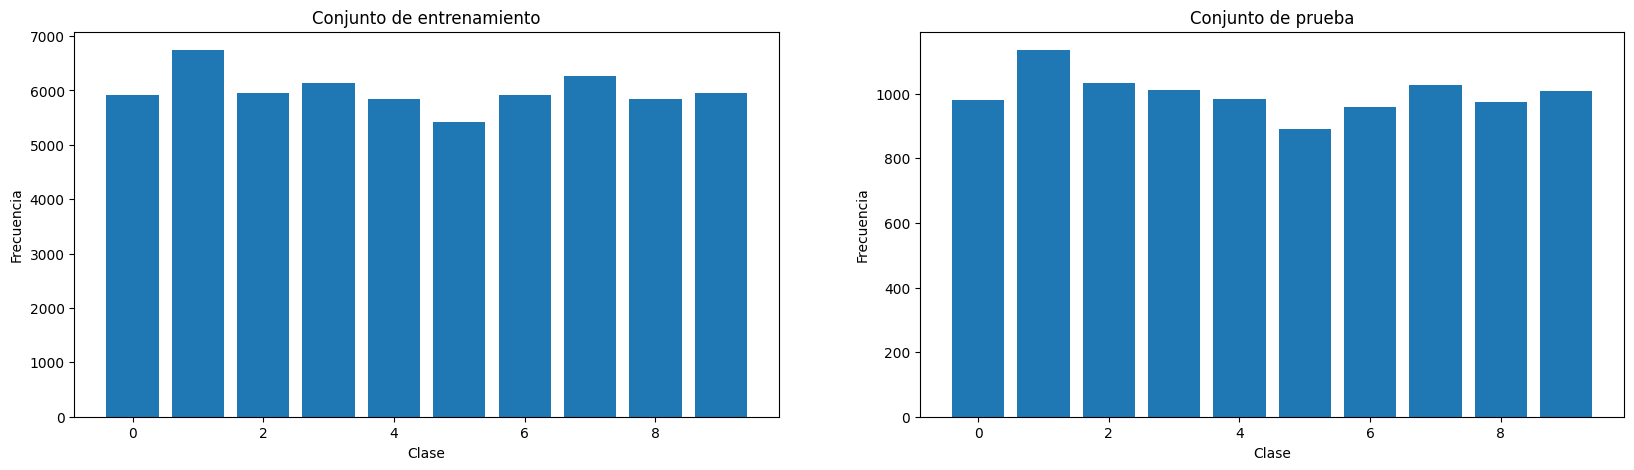

In [6]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
#plt.hist(train_labels[:], bins=10)
h = np.histogram(train_labels, bins=10)
plt.bar(range(0,10), h[0])
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.title('Conjunto de entrenamiento')

plt.subplot(1,2,2)
#plt.hist(test_labels[:], bins=10)
h = np.histogram(test_labels, bins=10)
plt.bar(range(0,10), h[0])
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.title('Conjunto de prueba')

plt.show()

### Datos de entrenamiento (primeros 60,000)

In [7]:
print('train images shape:', train_images.shape)
print('train labels shape:', train_labels.shape)

train images shape: (60000, 28, 28)
train labels shape: (60000,)


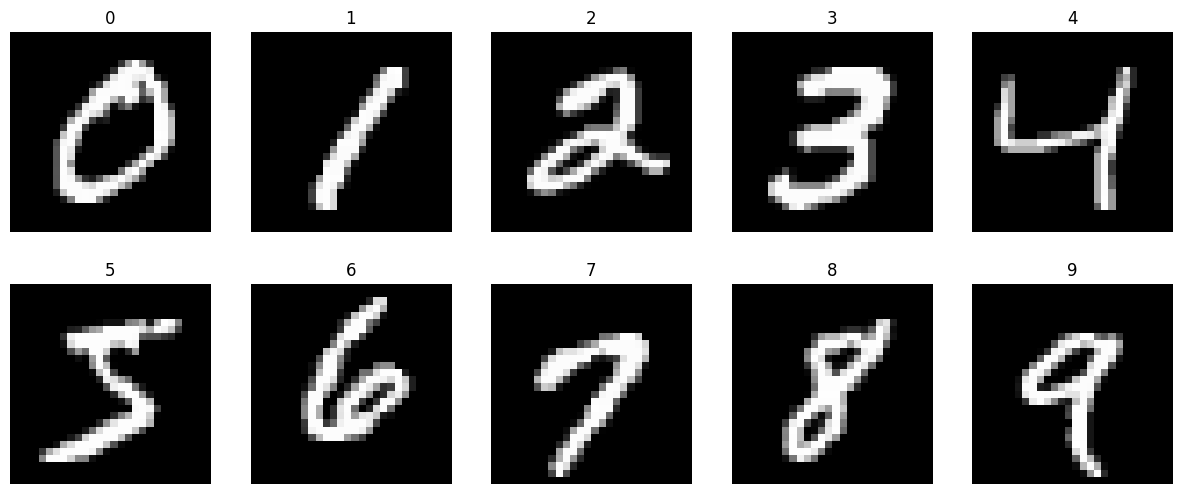

In [8]:
# Ejemplos de imágenes para cada clase

plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    idx = list(train_labels).index(i)
    plt.imshow(train_images[idx], cmap='gray')
    plt.title(train_labels[idx])
    plt.axis('off')   
plt.show()

### Primeras 400 ocurrencias de las imágenes de los dígitos 4 y 9.

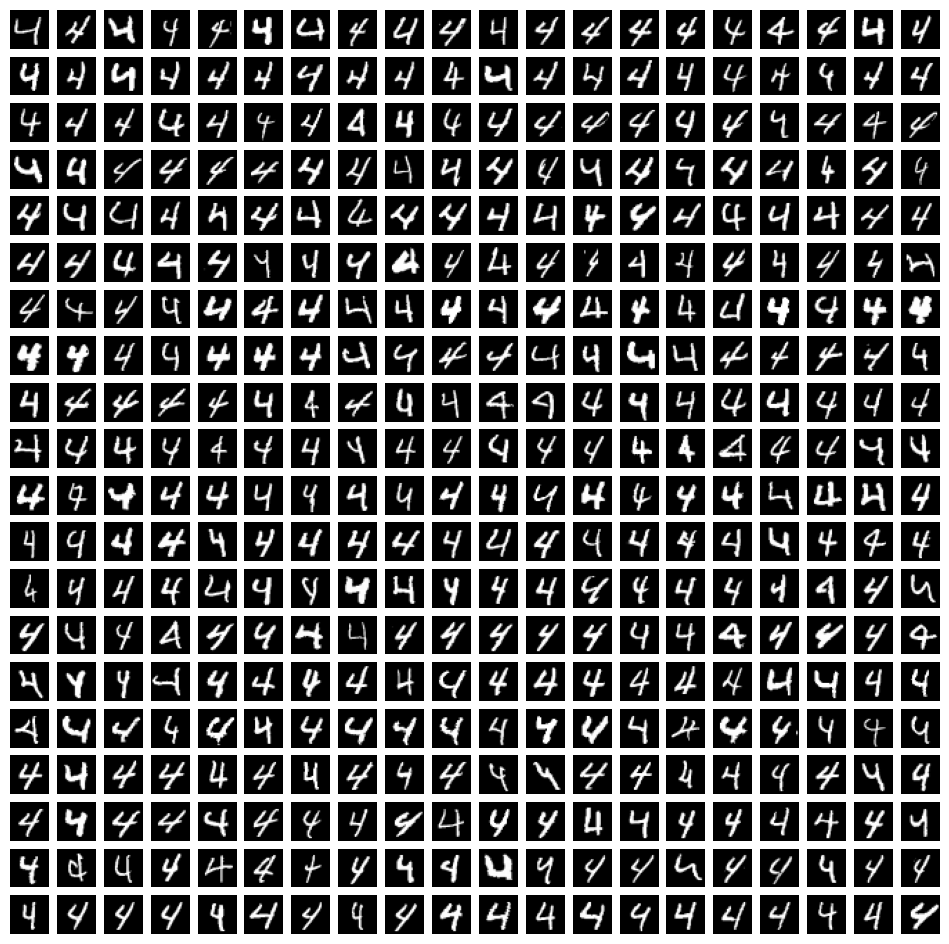

In [9]:
nrowsIm = 20
ncolsIm = 20
numIm = nrowsIm*ncolsIm

digit = 4
Indexes = np.where(train_labels==digit)[0][:numIm]

plt.figure(figsize=(12,12))
for i, idx in enumerate(Indexes[:numIm]):
    plt.subplot(nrowsIm,ncolsIm,i+1)
    plt.imshow(train_images[idx], cmap='gray')
    plt.axis('off')
    
plt.show()

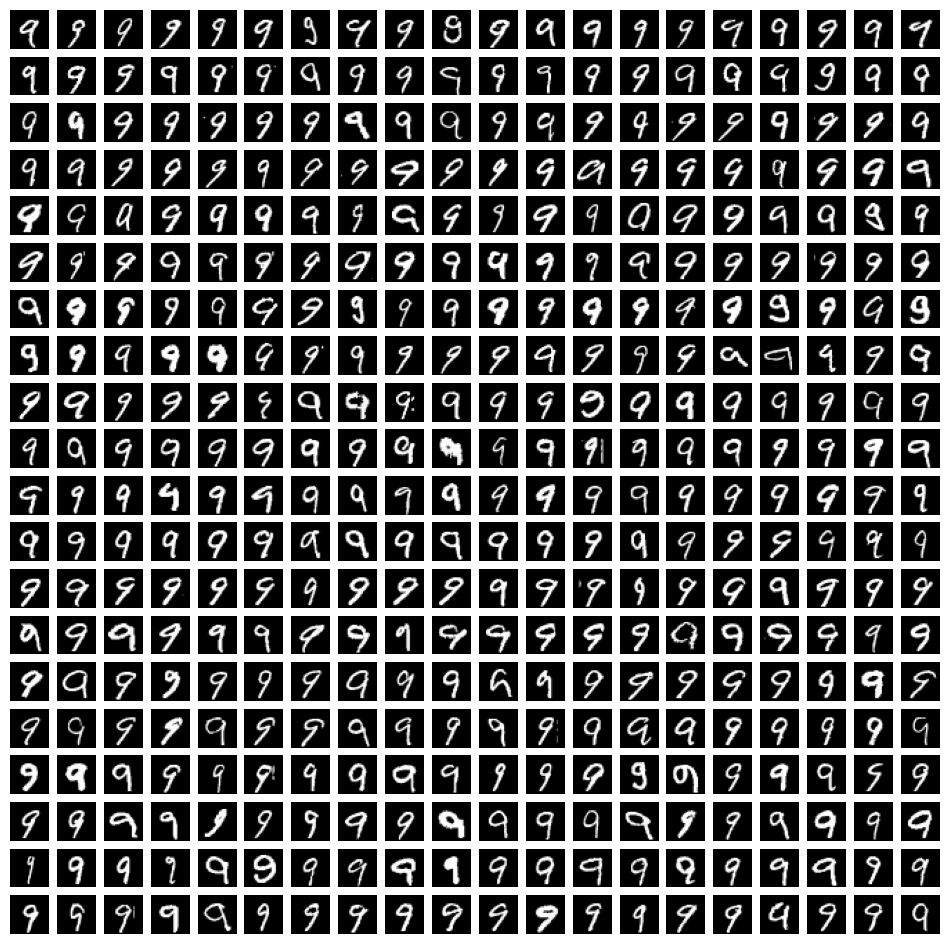

In [10]:
digit = 9
Indexes = np.where(train_labels==digit)[0][:numIm]

plt.figure(figsize=(12,12))
for i, idx in enumerate(Indexes[:numIm]):
    plt.subplot(nrowsIm,ncolsIm,i+1)
    plt.imshow(train_images[idx], cmap='gray')
    plt.axis('off')
    
plt.show()

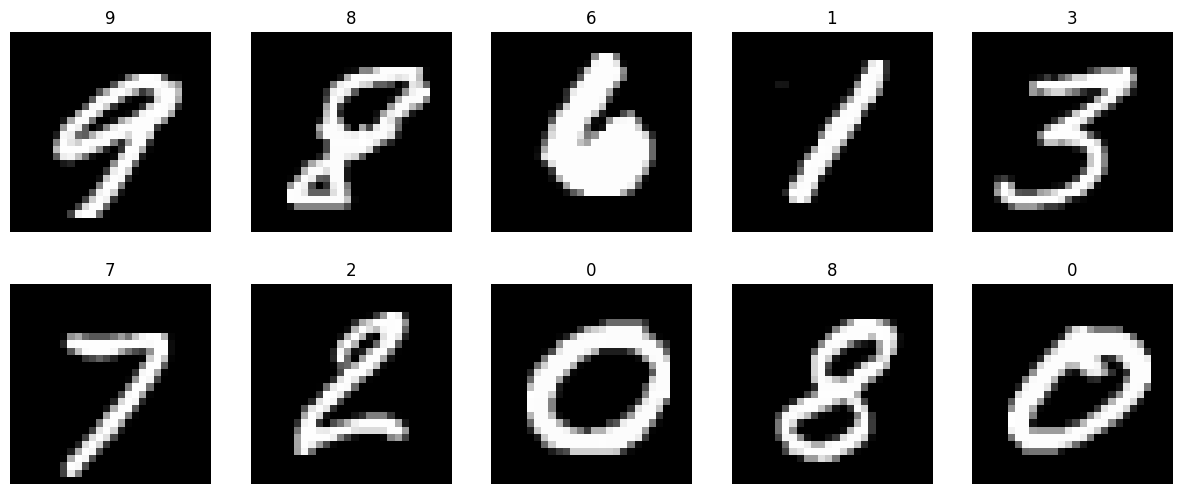

In [11]:
# Ejemplos de imágenes (de 500 en 500)

idx = (500*np.linspace(0,9,10) + 1005).astype(np.int)
plt.figure(figsize=(15,6))
for i in range(0, 10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_images[idx[i]], cmap='gray')
    plt.title(train_labels[idx[i]])
    plt.axis('off')
plt.show()

In [12]:
for i in range(0, 10):
    print('Train label', str(idx[i]), '=', train_labels[idx[i]])

Train label 1005 = 9
Train label 1505 = 8
Train label 2005 = 6
Train label 2505 = 1
Train label 3005 = 3
Train label 3505 = 7
Train label 4005 = 2
Train label 4505 = 0
Train label 5005 = 8
Train label 5505 = 0


## Preprocesamiento de los datos

Usaremos una red clasificadora, la cual trabajo con vetores de entrada unidimensionales (tensores de orden 1). Por lo que preprocesamos cada imagen para:

* transformarla de ser un tensor de orden 2 de $28 \times 28$ (pixeles por renglón, pixeles por columna, número de canales) a un tensor unimensional de $784$ entradas.

* normalizar en valores de cada entrada del intervalo $[0, 255]$ al intervalo $[0, 1]$.

In [13]:
train_images.max()

255

In [14]:
# reshape y normalización
train_images = train_images.reshape((60000, -1))
# reescalando al intervalo [0,1]
train_images = train_images.astype('float32') / 255.

__Ejercicio:__ Repita el reshape y la normalización para las imágenes de prueba (test_images) 

In [15]:
### START CODE HERE ### (≈ 2 lines of code)
test_images = test_images.reshape((10000, -1))

test_images = test_images.astype('float32') / 255
### END CODE HERE ###

In [18]:
# verificando las nuevas dimensiones
print('train images shape:', train_images.shape)
print('train labels shape:', train_labels.shape)
print('test images shape:', test_images.shape)
print('test labels shape:', test_labels.shape)

train images shape: (60000, 784)
train labels shape: (60000,)
test images shape: (10000, 784)
test labels shape: (10000,)


In [19]:
# verificando el rango dinámico de las imágenes
print('train_images min =', train_images.min())
print('train_images max =', train_images.max())
print('test_images min =', test_images.min())
print('test_images max =', test_images.max())

train_images min = 0.0
train_images max = 1.0
test_images min = 0.0
test_images max = 1.0


Además, cambiaremos el formato de las etiquetas. Pasaremos de estar codificadas en un entero en el conjunto $\{0,1,2,\ldots,9\}$ a ser un vector de la base canónica de $\mathbb{R}^{10}$, $\{\mathbf{e}_i\}_{i=1,2,\ldots,10}$.

El mapeo es simplemente
$$ i \mapsto \mathbf{e}_{i+1}, \ \ \text{para} \ i = 0, 1, 2, \ldots, 9. $$

Por ejemplo, la etiqueta $y = 3$ se mapea al vector $\mathbf{e}_4 = (0,0,0,1,0,0,0,0,0,0)$.

En al argot de redes neuronales, a esta codificación se denomina _one-hot_, o vectores indicadores en general, o variables categóricas.

En Keras este mapeo se realiza mediante el siguiente código.

In [20]:
from tensorflow.keras.utils import to_categorical

# one-hot enconding
train_labels = to_categorical(train_labels)

__Ejercicio:__ Repita el one-hot encoding para las etiquetas de prueba (test_labels) 

In [21]:
### START CODE HERE ### (≈ 1 line of code)
test_labels = to_categorical(test_labels)
### END CODE HERE ###

In [22]:
# verificando las nuevas dimensiones
print('train labels shape:', train_labels.shape)
print('test labels shape:', test_labels.shape)

train labels shape: (60000, 10)
test labels shape: (10000, 10)


In [23]:
for i in range(0, 10):
    print('Train label', str(idx[i]), '=', train_labels[idx[i]])

Train label 1005 = [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Train label 1505 = [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Train label 2005 = [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Train label 2505 = [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Train label 3005 = [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Train label 3505 = [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Train label 4005 = [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Train label 4505 = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Train label 5005 = [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Train label 5505 = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


---

---

## Arquitectura de una red neuronal multicapa

Lo primero que hacemos es definir el tipo de modelo red que usaremos.

El modelo más popular de NN para implementar clasificadores es el __Secuencial__. En una red secuencial, los datos se alimentan a la primera capa oculta y son procesador capa por capa (hacia adelante) hasta la capa de salida. Esta última capa (y portanto la red neuronal) tiene como salida el vector deseado de predicciones.

La arquitectura de nuestra primer red secuencial consiste en una capas oculta densamente conectada: todas las neuronas en una capa se conectan con todas la salidas de cada neurona de la capa anterior.

### Tipos de capas

__capa de entrada:__ Son las neuronas que representan los datos de entrada, no es necesario definir esta capa en Keras. Lo que requerimos es especificar las dimensiones de los datos en la primera capa oculta.

__primer capa oculta:__ los parámetros mínimos son el número de neuronas (units), la función de activación y la dimensión de los datos de entrada (1D).

__capas ocultas intermendias:__ los parámetros mínimos son el número de neuronas (units) y la función de activación. La dimensión de los datos de entrada corresponde al número de neuronas en la capa anterior.

__capa de salida:__ capa con la respuesta codificada, tendremos tantas neuronas como clases deseadas (Por ejemplo, en el caso de clasificacion de imágenes de dígitos de la base de datos MNIST, tendremos 10 neuronas, una por cada clase de dígito). Cada salida la intepretaremos como la probabilidad de que el dato de entrada pertenezca a dicha clase. Consecuentemente, usaremos 'softmax' como función de activación.

La siguiente figura muestra un esquema de la red secuencial propuesta.

![](secuencial.png)

En Keras, para definir un modelo secuencial se deben importar las librerías

In [24]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [25]:
# para inicializar un modelo NN secuencial nuevo
nn = models.Sequential()

In [ ]:
#nn.summary()

Existen distintos tipos de capas en una red secuencial.

En Keras, las capas ___Dense___ son son la capas de cálculo de que conectan cada neurona en una capa con todas las salidas de la capa anterior.

### Parámetros de una capa Densa (Dense)

__units:__ Número de neuronas (entero positivo), es la dimensión de la salida y por ende de entrada de la siguiente capa.

__activation:__ Función de activación (default, activación lineal: \phi(x)ϕ(x) = x).

__use_bias:__ {True, False}, si las neuronas de la capa tienen usan sesgo (bias).

__kernel_initializer:__ Inicializadores de la matriz de pesos de la capa; ver initializers.

__bias_initializer:__ Inicializador del vector de sesgos (bias).

__kernel_regularizer:__ Función de regularización aplicada a los pesos $(L1, L2, L1+L2)$; ver regularizers.

__bias_regularizer:__ Función de regularización aplicada al vector de bias.

__activity_regularizer:__ Función de regularización aplicada a las salidas de la capa.

__kernel_constraint:__ Función de restricción aplicada a los pesos de la capa (matriz de pesos); ver constraints.

__bias_constraint:__ Función de restricción aplicada al vector bias.

__name:__ Nombre de la capa.

---

---

## Definiendo una red neuronal simple 

<img src='nn1.png' alt='nn1' width='600'/>

In [26]:
train_images.shape

(60000, 784)

In [27]:
data_shape = train_images.shape[1:]
print(data_shape)

(784,)


In [28]:
# arquitectura de la red neuronal
if 'network' in globals(): del network
network = models.Sequential()

# añadimos una capa densa (primer capa oculta)
network.add(layers.Dense(32, activation='relu', input_shape=data_shape, name='dense1'))

In [ ]:
## Explicación:
#network.add(layers.Dense(units=32,                    # número de neuronas en la capa: 512
#                         activation='relu',            # función de activación: lineal rectificada (ReLU)
#                         input_shape=(28*28,)))        # forma de la entrada: (28*28 = 784
#                                                       # = tamaño de las imágenes vectorizadas)  
#                                                       # la otra dimensión es el tamano de lote (batch_size), 
#                                                       # que se define a la hora del entrenamiento 'fit'

__Ejercicio:__ Añadir una capa de salida, densa, con 10 neuronas y función de activación 'relu'.

In [29]:
### START CODE HERE ### (≈ 1 line of code)
network.add(layers.Dense(10,activation='relu',name='classifier'))
### END CODE HERE ###

Ahora podemos visualizar el resumen de la arquitectura

Nombre de la capa (Tipo) – Forma del vector de salida – Número de parámetros

In [30]:
network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 32)                25120     
                                                                 
 classifier (Dense)          (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


## Selección de los parámetros de entrenamiento (training)

Antes de pasar al proceso de entrenamiento de la red, es necesario definir lor parámetros del entrenamiento mediante el método _compile_ que tienen los siguientes parámetros:

__optimizer:__ Método de optimización, por ejemplo: gradiente estocástico (sgd), rmsprop, adagrad, adam, adamax, nadam, etc.

__loss (función de pérdida):__ Función objetivo a minimizar. Mide la disimilaridad entre el valor deseado (etiquetas de entrenamiento y el valor predicho por la red). Para el caso de probabilidades de variables categóricas es recomendable usar la cross-entropía categórica (categorical_crossentropy). Para el caso de clasificación binaria, la cross-entropía binaria (binary_crossentropy) es una función objetivo mas apropiada. Otras funciones de pérdida incluyen a la Error Cuadrático Medio (mse); el Error Absoluto Medio(mae); suma de log-cosh, etc.

__metrics:__ Lista de métricas a monitorear durante el proceso de entrenamiento. Una métrica a monitorear siempre adecuada es ‘accuracy’. Es posible incluir métricas definidas por el usuario.

In [31]:
# definir optimizador, función de pérdida y métricas

alpha = 0.1
opt = optimizers.Adam(learning_rate=alpha)

# caso binario       Loss = "binary_crossentropy"
# caso multiclase    Loss = "categorical_crossentropy"

# loss function
network.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### Selección del optimizador

Podemos seleccionar el algoritmo de optimización específico y ajustar sus parámetros. Por ejemplo, si en vez de usar _rmsprop_ en el caso anterio, usamos Descenso de Gradente Estocástico (SGD), podemos usar la variante con momentum del tipo Nesterov y con decaimiento del factor de aprendizaje después de cada actualización de lote (batch). En tal caso el código es como sigue

In [32]:
from tensorflow.keras import optimizers

# parámetros de metodo de optimización
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# parámetros del procedimiento de aprendizaje (incluye que optimizador usar)
nn = models.Sequential()
nn.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

ValueError: decay is deprecated in the new Keras optimizer, pleasecheck the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.SGD.

## Entrenamiento (Training)

Para realizar el entrenamiento se invoca a la función _fit_ que recibe parámetros sobre cómo los datos son empleados. Recordemos que el propósito de la NN es estimar la función entre las entradas, $x$, y las salidas $y$:
$$ y = f(x) $$

_Parámetros:_

__x:__ arreglo multidimensional (numpy) copn los datos de entrenamiento.

__y:__ arreglo multidimensional con las etiquetas esperadas.

__batch_size:__ número de muestras por cada actualización del gradiente (default, 32).

__epochs:__ número de veces (épocas) que el conjunto de entrenamiento es enteramente procesado (en lotes de batch_size en batch_size).

__verbose:__ entero {0, 1, 2}; modo de palabreo o verbosidad (verbosity): 0 = silencio, 1 = barra de progreso, 2 = línea por época.

__validation_split:__ flotante (float) en el intervalo $[0,1]$. Este representa la fracción de datos usados para validación. Los datos de validación no se usan en el entrenamiento y se usan para monitorear el progreso de la función de pérdida (loss) y las métricas (metric).

__validation_data:__ se puede pasar explícitamente el conjunto de validación mediante la tupla (x_val, y_val).

__shuffle:__ Boolena (boolean) indica si los datos de entrenamiento son remezclados anste de cada época.

__class_weight:__ lista con pesos relativos de las clases (índices). Forza a dar mas peso a la clasificación de ciertas clases.

__sample_weight:__ peso relativo de los datos de entrenamiento. Útil para pasar distintamente datos de distintas clases cuando la base de datos no esta balanceda.

__initial_epoch:__ época para iniciar el entrenamiento (para reanudar un entrenamiento en el punto suspendido).

__steps_per_epoch:__ número de pasos por época. Por default es el número de datso de entrenamiento dividido entre el tamaño de los lotes.

__validation_steps:__ sólo cuando se especifica steps_per_epoch, es el número de pasos de validación antes de parar.

---

También está

__callbacks:__ Lista de funciones callback a invocarse durante el entrenamiento y minitorear estados internos del modelo durante el entrenamiento.

_Regresa_

__History:__ El atributo history del objeto regresado History contienen los valores de la función objetivo y de las métricas a a través de las distintas épocas de entrenamiento.

In [35]:
# regresando a nuestro modelo
opt = optimizers.RMSprop(lr=0.001)
network.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# entrenando la red

tic = time()
history = network.fit(x=train_images, y=train_labels, epochs=5, batch_size=128, validation_split=0.16666,
                     verbose=1)
toc = time()
print('total training time:', toc-tic, 'seconds')

Epoch 1/5
391/391 [==============================] - 4s 7ms/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0991
Epoch 2/5
391/391 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0991
Epoch 3/5
391/391 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0991
Epoch 4/5
391/391 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0991
Epoch 5/5
391/391 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0991
total training time: 13.90189504623413 seconds


Entrenar una red requiere hallar un juego ideal de parámetros, en donde el algoritmo de optimización converge a un punto estacionario (mínimo local).

En el lenguaje de deep learning, este proceso se llama _parameter tunning_.

### ¿Cómo debe verse la evolución ideal de la función de pérdida?

![](learningrates.jpeg)

### Parameter Tunning

In [37]:
# borramos la red, si ya había sido creada
if 'network' in globals(): del network

# re-definimos la red (de nuevo)
network = models.Sequential()
network.add(layers.Dense(32, activation='relu', input_shape=(28*28,), name='dense1'))
network.add(layers.Dense(10, activation='softmax', name='classifier'))

# resumen
network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 32)                25120     
                                                                 
 classifier (Dense)          (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


__Ejercicio:__ Defina un optimizador 'RMSprop', con tasa de aprendizaje (learning rate) lr=0.0075.
Luego, defina su red neuronal para utilizar este optimizador, y las funciones de pérdida y métricas adecuadas.

In [38]:
### START CODE HERE ### (≈ 2 lines of code)

### END CODE HERE ###








opt = optimizers.RMSprop(lr=0.001)

#opt = optimizers.RMSprop(lr=0.0075)
network.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

__Ejercicio:__ Entrene nuevamente la red neuronal. Utilice epochs=15, batch_size=128, validation_split=0.16666.

In [ ]:
### START CODE HERE ### (≈ 4 line of code)




### END CODE HERE ###

### Conjuntos de entrenamiento, validación y prueba

Podemos notar:

El valor de la función objetivo alcanzado es cercano a:

3e-2 (0.03) para los datos del conjunto de entrenamiento.

1e-1 (0.09) para el conjunto de validación (sustancialmente mayor, mayor es peor).

Algo similar pasa con la métrica (accuracy):

99.9% para conjunto de entrenamiento.

97.9% para el conjunto de validación (menor es peor).

Esta disparidad en los valores se debe a que la red no utilizó los datos de validación para ajustar los pesos (nunca vio los datos de validación). El desempeño de la red en el conjunto de validación sería el desempeño esperado en datos no observados, como los datos de prueba. Lo que ha ocurrido es que la red ha memorizado algunas características presentes en los datos de entrenamiento que no están presentes en los datos de validación. Estas características que hacen la diferencia son muy particulares de algunos datos y no se les puede considerar atributos del universo de datos. Este error (diferencia entre desempeño en datos no observados vs. datos con que se entrenó el clasificador) se conoce como error de generalización y se debe a un sobreentrenamiento (sobreajuste) de la red en el conjunto de entrenamiento, también denominado _overfitting_.

La razón por la que no hemos evaluado la red en el conjunto de prueba es que nuestro diseño final debe evaluarse solo una vez en el conjunto de prueba. Las razón es:

Cada vez que modificamos algún parámetro de la red (número de capas, número de neurones an las capas, funciónes de activación, función de perdida, etc.) a razón de mejorar el desempeño en el conjunto de datos de validación del modelode que estamos diseñando, actuamos, de hecho, como un optimizador de la función objetivo, y en el proceso podemos llegar a un sobreajuste de los datos de validación. Perdiendo con ello al caracteristica de totalmente no observable el conjunto de validación.

Es como si en cada iteración de nuestro proceso de diseño de la NN, parte de la información del conjuento de validación se fuera pasando al conjunto de entrenamiento en un proceso de fuga de información (_information leak_).

### Ver historial de desempeño

Para analizar como se comportan los valores de la función objetivo y de las métricas, analizamos el objeto _history_ devuelto por el proceso de entrenamiento.

In [39]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

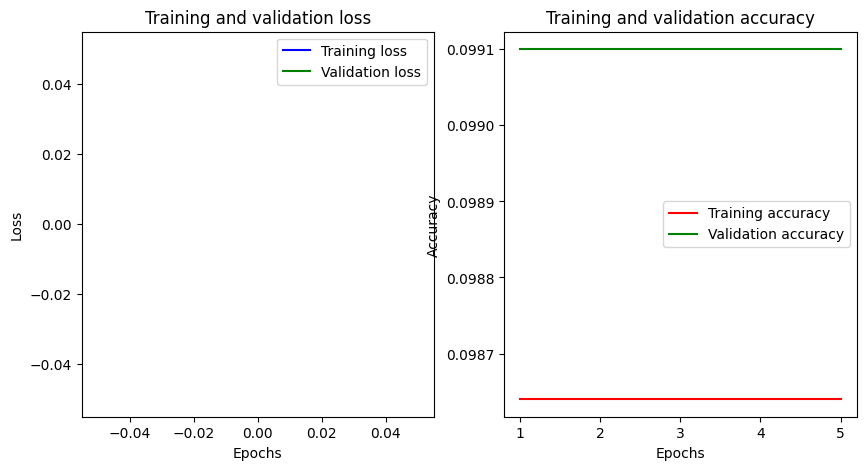

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

# figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Resultados

In [ ]:
from pandas import DataFrame
#from pandas_ml import ConfusionMatrix
from sklearn.metrics import confusion_matrix
from plotmatrix import pretty_plot_confusion_matrix

In [ ]:
pred = network.predict(test_images)
predictions = np.argmax(pred, 1)

In [ ]:
test_labs = np.argmax(test_labels, 1)
#conf_matrix = ConfusionMatrix(test_labs, predictions)
CM = confusion_matrix(test_labs, predictions)

In [ ]:
print(CM)

In [ ]:
cf = DataFrame(CM)
pretty_plot_confusion_matrix(cf, annot=True, pred_val_axis='x', figsize=(10,10), fz=12)

In [ ]:
# another plot
from plotmatrix import PlotMatrix
PlotMatrix(CM, figsize=(10,10), cmap=plt.cm.Blues, title='Confusion Matrix', fz=15)

## Guardar y abrir modelos

En Keras, existe una opción para guardar la arquitectura y pesos de una red neuronal entrenada. La información de la red neuronal se guarda en un archivo de formato __.h5__

Se hace de la siguiente forma:

In [ ]:
# guardar la red network
network.save('nn1.h5')         # path + filename

Para abrir un modelo ya guardado.

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('nn1.h5')   # path + filename

In [ ]:
model.summary()

In [ ]:
# información de las capas
model.layers

In [ ]:
for l in model.layers:
    print(l.name)

In [ ]:
L = model.get_layer('dense1')
print('layer name:', L.name)
#print('input shape:', L.batch_input_shape)
print('activation:', L.activation)
print('bias:', L.bias)
#print('weights:', L.weights)

In [ ]:
# información de los pesos
model.weights

In [ ]:
# recuperar los pesos W_ij
W = model.get_weights()
print('Weight shapes:')
for i in range(0, len(W)):
    if (i%2 == 0): print('W_' + str(i//2) + '=', W[i].shape)
    else: print('b_' + str(i//2) + '=', W[i].shape)

In [ ]:
# imprimimos los pesos de la capa de salida
print('W_1 =')
print(np.round(W[2], 2))

In [ ]:
# imprimimos los bias de la capa de salida
print('b_1 =')
print(np.round(W[3], 2))

### Diseño final

El código completo y final del clasificador de red multicapa sigue a continuación.

In [ ]:
# cargar la interfaz a la base de datos que viene con Keras
from tensorflow.keras.datasets import mnist

# lectura de los datos
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# pre-procesamiento de los datos
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

data_shape = train_images.shape[1:]

# one-hot encoding
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels  = to_categorical(test_labels)

# Arquitectura de la red
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

if 'network' in globals(): del network
network = models.Sequential()    
network.add(layers.Dense(units=512, activation='relu', input_shape=data_shape, name='dense1'))
network.add(layers.Dense(units=10, activation='softmax', name='classifier'))

opt = optimizers.RMSprop(lr=0.001)            
network.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

tic = time()
history = network.fit(train_images, train_labels, epochs=7, batch_size=128, validation_split=.16666)
toc = time()
print('total training time:', toc-tic, 'seconds')

#### Resultados

In [ ]:
#results = network.evaluate(test_images, test_labels)
#print('results loss:', results[0])
#print('results accuracy:', results[1])

In [ ]:
from pandas import DataFrame
from sklearn.metrics import confusion_matrix
from plotmatrix import pretty_plot_confusion_matrix

pred = network.predict(test_images)
predictions = np.argmax(pred, 1)

test_labs = np.argmax(test_labels, 1)
CM = confusion_matrix(test_labs, predictions)

# plot confusion matrix
cf = DataFrame(CM)
pretty_plot_confusion_matrix(cf, annot=True, pred_val_axis='x', figsize=(10,10), fz=12)

In [ ]:
# other plot
PlotMatrix(CM, figsize=(10,10), cmap=plt.cm.Blues, title='Confusion Matrix', fz=15)

In [ ]:
# salvar modelo final
network.save('nn1.h5')

---

---